In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/A_test.jpg
/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/E_test.jpg
/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/L_test.jpg
/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/N_test.jpg
/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/S_test.jpg
/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/D_test.jpg
/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/G_test.jpg
/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/I_test.jpg
/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/W_test.jpg
/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/M_test.jpg
/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/nothing_test.jpg
/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/X_test.jpg
/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test/H_test.jpg
/kaggle/input/asl-alphabet/asl_a

In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical

# Model and layers
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization

# Training utilities
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

2025-11-01 05:01:42.838976: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761973303.056856      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761973303.109883      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from tensorflow.keras.mixed_precision import set_global_policy

# Enable mixed precision for faster GPU training
set_global_policy('mixed_float16')

In [4]:
# source and target folders
source_dir = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train"
base_dir = "/kaggle/working/asl-alphabet_split"   # new folder for split data
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# create new directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# train/validation ratio
split_ratio = 0.8  # 80% train, 20% test

# go through each class (A–Z, del, nothing, space)
for cls in os.listdir(source_dir):
    cls_path = os.path.join(source_dir, cls)
    if os.path.isdir(cls_path):
        # only include files, skip directories
        images = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
        if not images:
            continue

        # split
        train_files, test_files = train_test_split(images, test_size=1 - split_ratio, random_state=42)

        # create class subfolders
        os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
        os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

        # copy files
        for f in train_files:
            shutil.copy(os.path.join(cls_path, f), os.path.join(train_dir, cls, f))
        for f in test_files:
            shutil.copy(os.path.join(cls_path, f), os.path.join(test_dir, cls, f))

print("✅ Split complete! Data saved in 'asl-alphabet_split/train' and 'asl-alphabet_split/test'")


✅ Split complete! Data saved in 'asl-alphabet_split/train' and 'asl-alphabet_split/test'


In [5]:
# paths
train_dir = "/kaggle/working/asl-alphabet_split/train"
test_dir = "/kaggle/working/asl-alphabet_split/test"

# image parameters
img_size = (220, 220)
batch_size = 32

# data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# create data loaders
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


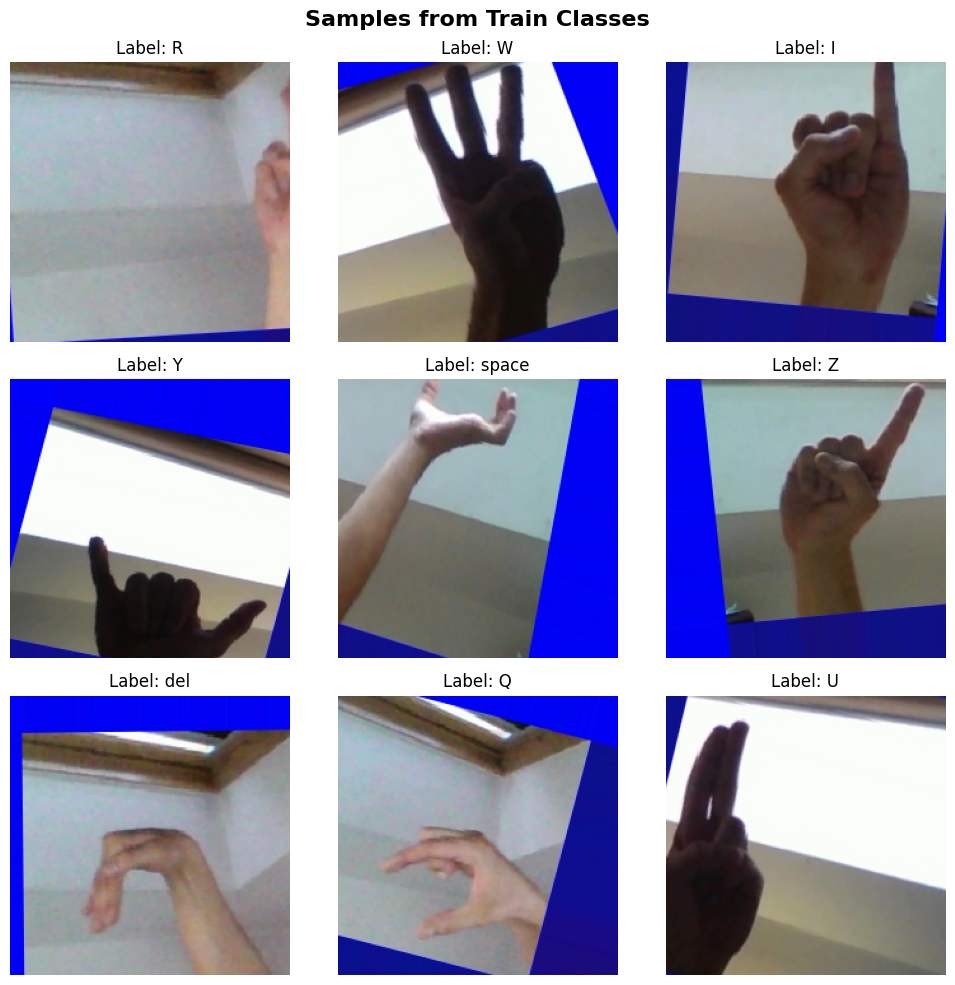

In [6]:
# get a batch of images and labels
images, labels = next(train_generator)

# show 9 random samples
plt.figure(figsize=(10, 10))
plt.suptitle("Samples from Train Classes", fontsize=16, fontweight='bold')
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {list(train_generator.class_indices.keys())[np.argmax(labels[i])]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


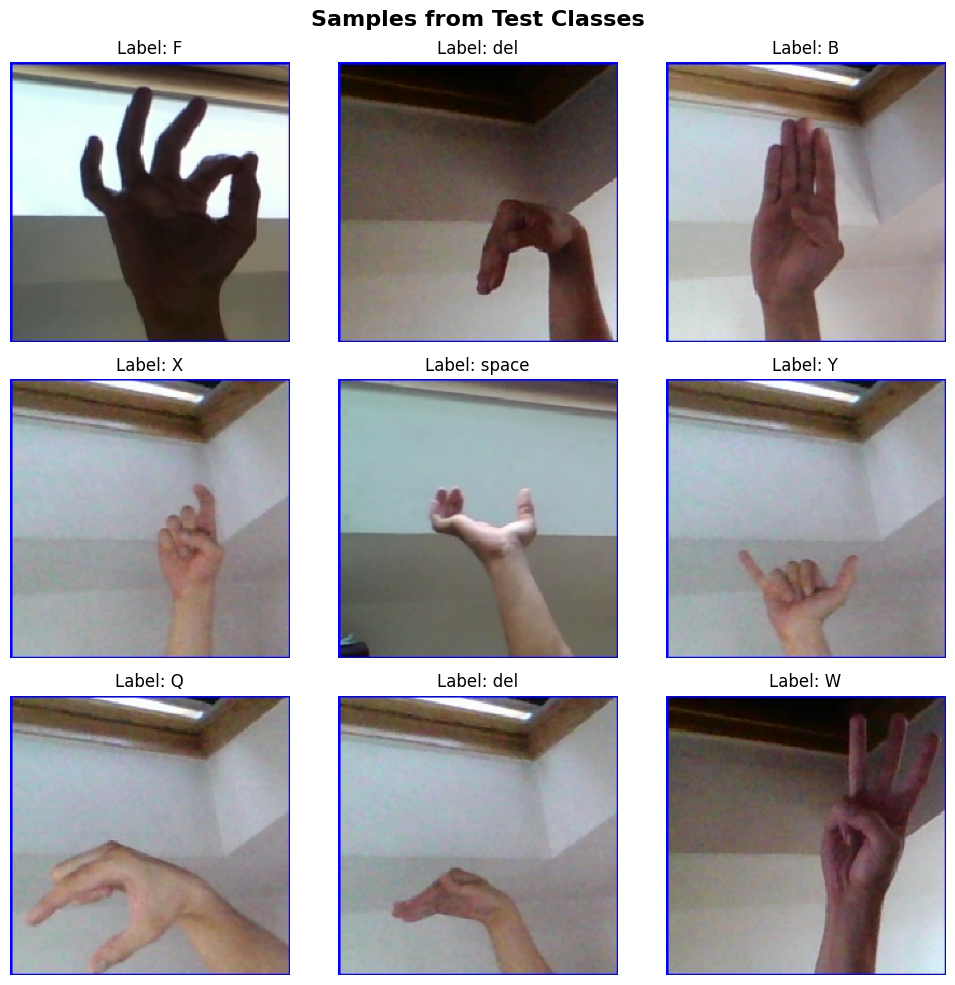

In [7]:
# get a batch of images and labels
images, labels = next(test_generator)

# show 9 random samples
plt.figure(figsize=(10, 10))
plt.suptitle("Samples from Test Classes", fontsize=16, fontweight='bold')
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {list(test_generator.class_indices.keys())[np.argmax(labels[i])]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [8]:
# load VGG19 base (without top layers)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(220, 220, 3))

# freeze base layers (so pretrained features remain fixed initially)
for layer in base_model.layers:
    layer.trainable = False

# add custom classification head
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
output = Dense(train_generator.num_classes, activation='softmax', dtype='float32')(x)

# combine base + head
model = Model(inputs=base_model.input, outputs=output)

model.summary()

# compile model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# callbacks
checkpoint = ModelCheckpoint("best_vgg19_asl.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# train model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[checkpoint, early_stop]
)


I0000 00:00:1761973861.482574      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761973861.483262      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 220, 220, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 220, 220, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 220, 220, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 220, 220, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 110, 110, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 110, 110, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 110, 110, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 55, 55, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 55, 55, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 55, 55, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 55, 55, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 55, 55, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 27, 27, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 27, 27, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 27, 27, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 27, 27, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 27, 27, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 13, 13, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 13, 13, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 13, 13, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 13, 13, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 13, 13, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,69

 Total params: 29,603,933 (112.93 MB)

 Trainable params: 9,578,013 (36.54 MB)

 Non-trainable params: 20,025,920 (76.39 MB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1761973867.906166     130 service.cc:148] XLA service 0x787108009880 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761973867.907279     130 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761973867.907302     130 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761973868.516990     130 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/2175 ━━━━━━━━━━━━━━━━━━━━ 2:56 81ms/step - accuracy: 0.0391 - loss: 4.6930   

I0000 00:00:1761973881.767529     130 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.4053 - loss: 2.2016
Epoch 1: val_accuracy improved from -inf to 0.86230, saving model to best_vgg19_asl.h5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 760s 341ms/step - accuracy: 0.4053 - loss: 2.2013 - val_accuracy: 0.8623 - val_loss: 0.4597
Epoch 2/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.7081 - loss: 0.9627
Epoch 2: val_accuracy improved from 0.86230 to 0.90718, saving model to best_vgg19_asl.h5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 718s 330ms/step - accuracy: 0.7082 - loss: 0.9626 - val_accuracy: 0.9072 - val_loss: 0.3006
Epoch 3/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.7643 - loss: 0.7662
Epoch 3: val_accuracy improved from 0.90718 to 0.92741, saving model to best_vgg19_asl.h5
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 721s 332ms/step - accuracy: 0.7643 - loss: 0.7662 - val_accuracy: 0.9274 - val_loss: 0.2411
Epoch 4/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.7902 - loss: 0.6786
Epoch 4: val_ac

In [9]:
# evaluate on validation data
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {test_acc * 100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")


544/544 ━━━━━━━━━━━━━━━━━━━━ 34s 63ms/step - accuracy: 0.9576 - loss: 0.1437
✅ Test Accuracy: 95.87%
📉 Test Loss: 0.1407


In [10]:
# After training
print("Final Training Accuracy:", history.history['accuracy'][-1])
print("Final Validation Accuracy:", history.history['val_accuracy'][-1])
print("Final Training Loss:", history.history['loss'][-1])
print("Final Validation Loss:", history.history['val_loss'][-1])

Final Training Accuracy: 0.8501867651939392
Final Validation Accuracy: 0.9560344815254211
Final Training Loss: 0.47914448380470276
Final Validation Loss: 0.13945040106773376


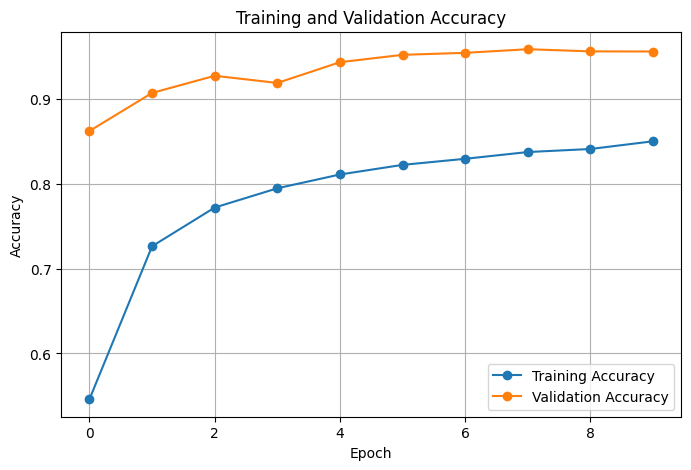

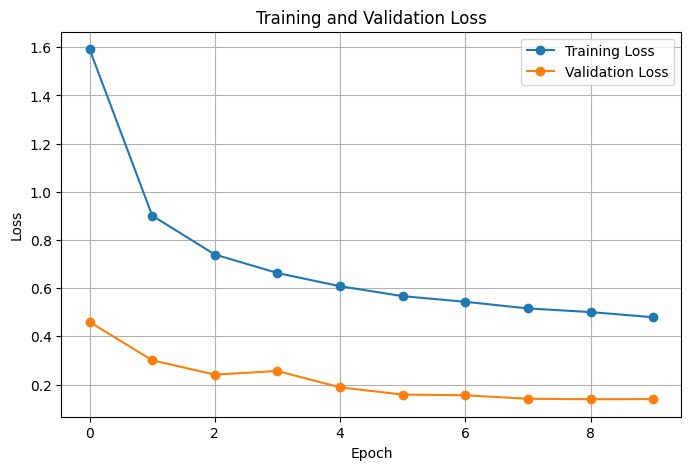

In [11]:
# Plot Accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
model.save('best_vgg19_asl.keras')
model = tf.keras.models.load_model('best_vgg19_asl.keras')

Found 17400 images belonging to 29 classes.
544/544 ━━━━━━━━━━━━━━━━━━━━ 37s 66ms/step


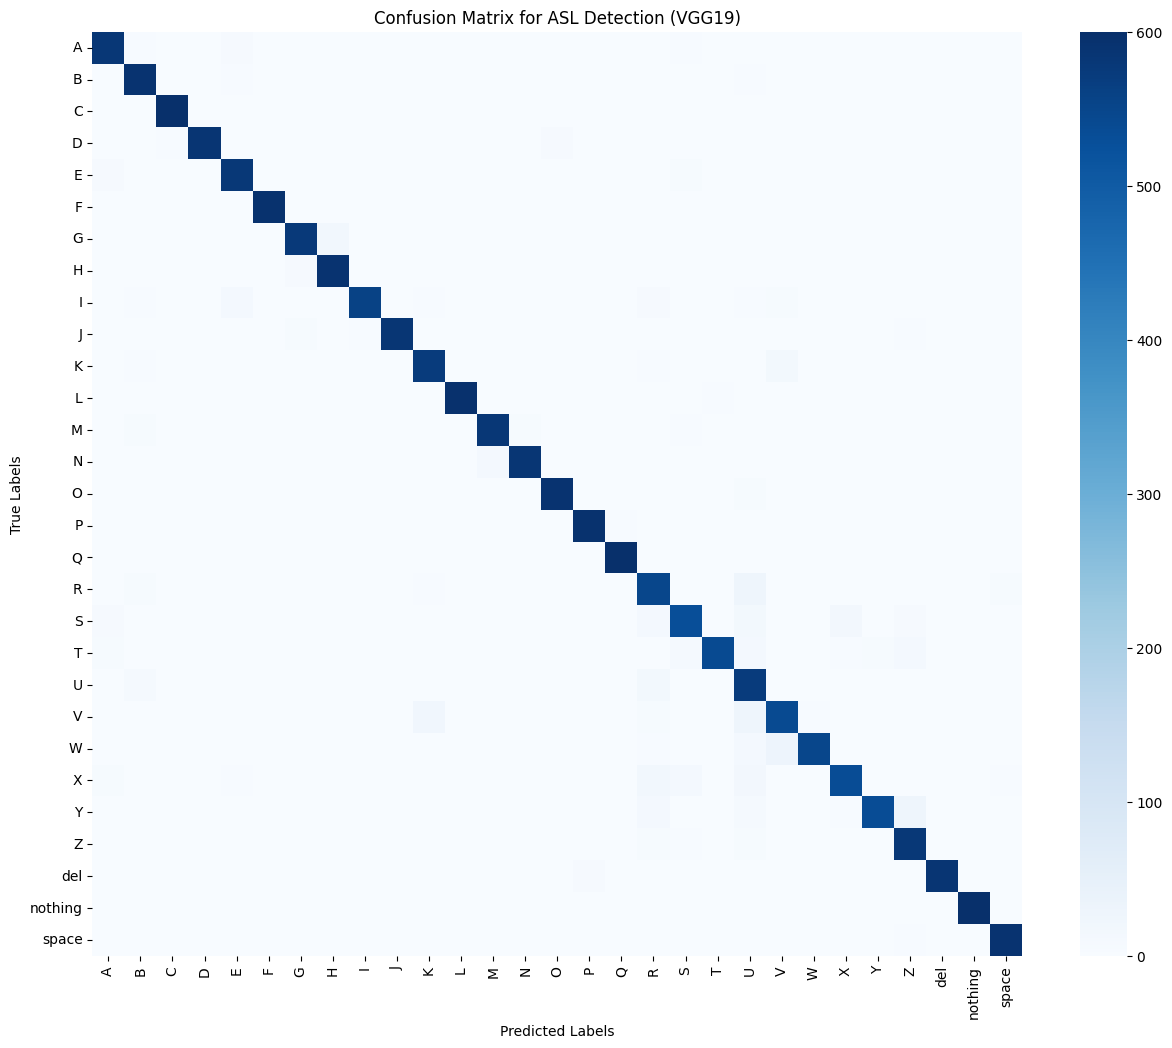

In [20]:
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load model
model.save('best_vgg19_asl.keras')

# Data generator (no shuffle!)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(220, 220),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# get true and predicted labels
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# plot confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix for ASL Detection (VGG19)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [21]:
# predictions
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# report
print(classification_report(test_generator.classes, y_pred, target_names=list(test_generator.class_indices.keys())))


544/544 ━━━━━━━━━━━━━━━━━━━━ 34s 62ms/step
              precision    recall  f1-score   support

           A       0.94      0.97      0.96       600
           B       0.94      0.99      0.96       600
           C       0.99      1.00      1.00       600
           D       1.00      0.98      0.99       600
           E       0.94      0.97      0.95       600
           F       0.99      0.99      0.99       600
           G       0.97      0.96      0.97       600
           H       0.96      0.99      0.97       600
           I       0.99      0.93      0.96       600
           J       0.99      0.97      0.98       600
           K       0.95      0.96      0.95       600
           L       1.00      0.99      1.00       600
           M       0.97      0.97      0.97       600
           N       0.99      0.97      0.98       600
           O       0.98      0.99      0.98       600
           P       0.99      0.99      0.99       600
           Q       1.00      1.00     

In [24]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# --- Unfreeze top VGG19 layers for fine-tuning ---
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the top 2 convolutional blocks (last 8–10 layers)
for layer in base_model.layers[-10:]:
    layer.trainable = True

# --- Compile with a small learning rate ---
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- Callbacks for stable training ---
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_vgg19_finetuned.keras', monitor='val_accuracy',
                    save_best_only=True, verbose=1)
]

# --- Fine-tune for 3 epochs ---
history_finetune = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=3,
    callbacks=callbacks
)


Epoch 1/3
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.8486 - loss: 0.4798
Epoch 1: val_accuracy improved from -inf to 0.96718, saving model to best_vgg19_finetuned.keras
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 724s 330ms/step - accuracy: 0.8486 - loss: 0.4798 - val_accuracy: 0.9672 - val_loss: 0.1159 - learning_rate: 1.0000e-05
Epoch 2/3
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.8644 - loss: 0.4308
Epoch 2: val_accuracy improved from 0.96718 to 0.96920, saving model to best_vgg19_finetuned.keras
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 710s 326ms/step - accuracy: 0.8644 - loss: 0.4308 - val_accuracy: 0.9692 - val_loss: 0.1077 - learning_rate: 1.0000e-05
Epoch 3/3
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.8659 - loss: 0.4211
Epoch 3: val_accuracy improved from 0.96920 to 0.96994, saving model to best_vgg19_finetuned.keras
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 725s 333ms/step - accuracy: 0.8659 - loss: 0.4211 - val_accuracy: 0.9699 - val_loss: 0.1037 - learning_rat

In [25]:
# Evaluate after fine-tuning
loss, acc = model.evaluate(test_generator)
print(f"Fine-tuned Test Accuracy: {acc * 100:.2f}")
print(f"Fine-tuned Test Loss: {loss:.4f}")

544/544 ━━━━━━━━━━━━━━━━━━━━ 35s 63ms/step - accuracy: 0.9763 - loss: 0.0811
Fine-tuned Test Accuracy: 96.99
Fine-tuned Test Loss: 0.1037


In [26]:
# After training
print("Final Training Accuracy:", history_finetune.history['accuracy'][-1])
print("Final Validation Accuracy:", history_finetune.history['val_accuracy'][-1])
print("Final Training Loss:", history_finetune.history['loss'][-1])
print("Final Validation Loss:", history_finetune.history['val_loss'][-1])

Final Training Accuracy: 0.8670258522033691
Final Validation Accuracy: 0.9699425101280212
Final Training Loss: 0.4159902036190033
Final Validation Loss: 0.10374239832162857


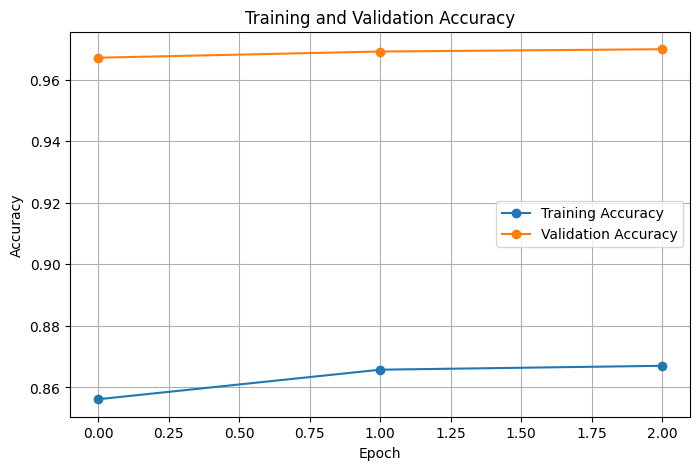

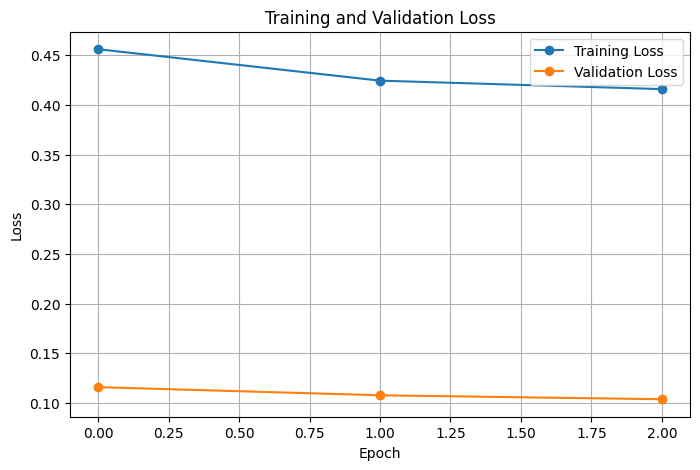

In [27]:
# Plot Accuracy
plt.figure(figsize=(8,5))
plt.plot(history_finetune.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(history_finetune.history['loss'], label='Training Loss', marker='o')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


544/544 ━━━━━━━━━━━━━━━━━━━━ 35s 64ms/step


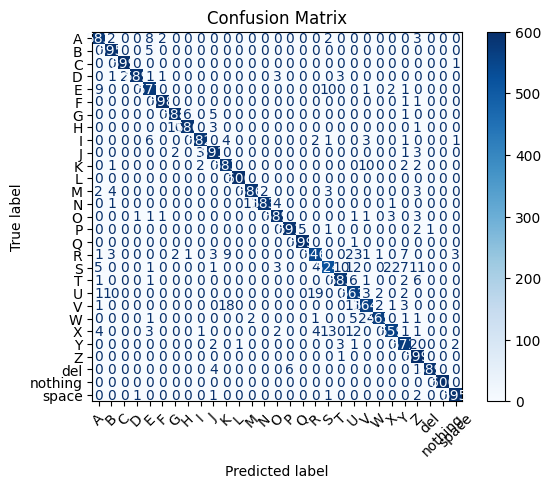

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay

# Get predictions
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Compute confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)
labels = list(test_generator.class_indices.keys())

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [32]:
# Generate report
labels = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=labels))


              precision    recall  f1-score   support

           A       0.96      0.97      0.97       600
           B       0.96      0.99      0.98       600
           C       1.00      1.00      1.00       600
           D       1.00      0.98      0.99       600
           E       0.96      0.96      0.96       600
           F       0.99      1.00      1.00       600
           G       0.98      0.98      0.98       600
           H       0.99      0.98      0.98       600
           I       0.99      0.97      0.98       600
           J       0.97      0.98      0.98       600
           K       0.95      0.97      0.96       600
           L       1.00      1.00      1.00       600
           M       0.98      0.98      0.98       600
           N       1.00      0.97      0.98       600
           O       0.98      0.98      0.98       600
           P       0.99      0.98      0.99       600
           Q       0.99      1.00      1.00       600
           R       0.95    

In [33]:
# Get predictions
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Display actual vs predicted
for i in range(10):  # show first 10 samples
    print(f"Actual: {class_labels[y_true[i]]}  |  Predicted: {class_labels[y_pred[i]]}")


544/544 ━━━━━━━━━━━━━━━━━━━━ 35s 63ms/step
Actual: A  |  Predicted: A
Actual: A  |  Predicted: A
Actual: A  |  Predicted: A
Actual: A  |  Predicted: A
Actual: A  |  Predicted: A
Actual: A  |  Predicted: A
Actual: A  |  Predicted: A
Actual: A  |  Predicted: A
Actual: A  |  Predicted: A
Actual: A  |  Predicted: A
